# LoC image analysis

This notebook is designed to take the tracks and assess a single-cell analysis of fluorescent marker expression

1. Load tracks
2. Filter for length
3. Extract max values
4. Plot

In [2]:
import os
import glob
from octopusheavy import DaskOctopusHeavyLoader
import napari
from skimage.io import imshow,  imsave, imread
import napari
import btrack
from tqdm.auto import tqdm
import dask.array as da

In [32]:
class channels(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 0
    SPC = 1
    PDPN = 2
    ZO1 = 3

# Load tracks

In [16]:
root_path = '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy'
expt_IDs = ['co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-SPC-PDPN-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60_/images/',
            'co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-VWF-iCAM1-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_70_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_150_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_262_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_130_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_253_/images/'
           ]

In [4]:
tracks_fn = 'beta_tracks/co-culture_iVECs+iAT2AT1_Folder_20220808_A2-A5_analysis_20221125_DAPI-SPC-PDPN-ZO1__20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60__tracks.hdf5'

In [ ]:
with btrack.dataio.HDF5FileHandler(tracks_fn, "r", obj_type="obj_type_1") as hdf:
    tracks = hdf.tracks

# Extracting single cell info

(array([4.615e+03, 1.675e+03, 2.279e+03, 6.410e+02, 3.230e+02, 2.300e+02,
        7.500e+01, 5.000e+01, 1.100e+01, 2.000e+00]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <BarContainer object of 10 artists>)

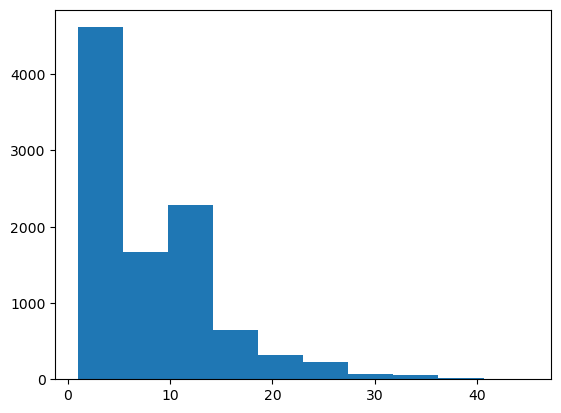

In [16]:
plt.hist([len(track) for track in tracks])

In [17]:
filtered_tracks = [track for track in tracks if len(track) >3]

In [36]:
import numpy as np
import pandas as pd

In [37]:
### define parameters to plot in table
cols = ['Cell ID', f'Max. int. {channels(0).name}', f'Max. int. {channels(1).name}', f'Max. int. {channels(2).name}', f'Max. int. {channels(3).name}', 'Average X', 'Average Y']
### extract some intial measurements
df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in filtered_tracks], columns= cols)

In [38]:
df

Cell ID  Max. int. DAPI  Max. int. SPC  Max. int. PDPN  Max. int. ZO1  \
0          84      216.148137     256.254388      708.973764     304.946782   
1          76      132.621622     173.988072      217.620278     208.888668   
2          70      128.000000     117.615385      125.815385     124.948052   
3          71      106.754902     113.752212      132.044248     136.707965   
4          72      111.000000     152.245763      284.720339     148.432203   
...       ...             ...            ...             ...            ...   
6104    11533      105.372881     108.620253      109.379747     115.443038   
6105    11527      105.321678     113.662420      113.318471     121.121019   
6106    11526      106.464286     113.160714      112.660714     123.206897   
6107    11522      107.577869     118.851485      117.137931     125.068966   
6108    11550      104.576087     109.885870      112.886364     117.190217   

        Average X    Average Y  
0     1775.768867  1033.838209  
1     2089.845109   887.967882  
2     2078.486081     8.384449  
3     2101.134548     5.889780  
4     1794.412976   520.435074  
...           ...          ...  
6104   705.839573     4.299024  
6105  2297.713839  1453.302570  
6106  2297.784021  1439.364378  
6107     6.549068  1290.065281  
6108  2298.429965   626.377223  

[6109 rows x 7 columns]

# Calculating the number of cells above/below threshold

In [39]:
pdpn_thresh = 400
spc_thresh = 350

In [42]:
print(f'Number of PDPN positive cells:', len(df[df['Max. int. PDPN'] > pdpn_thresh]))
print(f'Number of PDPN negative cells:', len(df[df['Max. int. PDPN'] < pdpn_thresh]))
print(f'Number of SPC positive cells:', len(df[df['Max. int. PDPN'] > spc_thresh]))
print(f'Number of SPC negative cells:', len(df[df['Max. int. PDPN'] < spc_thresh]))

Number of PDPN positive cells: 1951
Number of PDPN negative cells: 4158
Number of SPC positive cells: 3127
Number of SPC negative cells: 2982


## Distribution of maximum pixel values

In [44]:
import seaborn as sns

In [114]:
percentage_pos_pdpn = round(len(df[df['Max. int. PDPN'] > pdpn_thresh])/len(df)*100, 2)

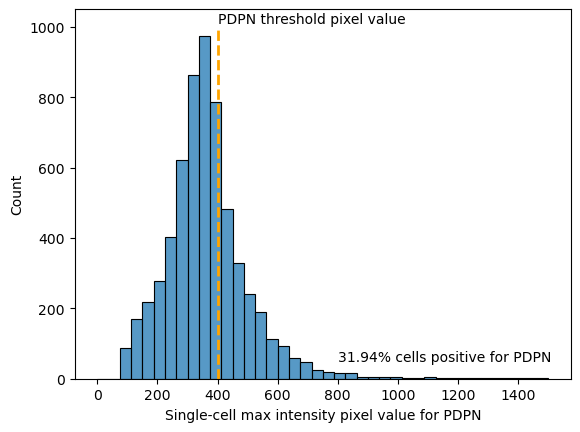

In [120]:
sns.histplot(df['Max. int. PDPN'], binrange=(0,1500), bins = 40, kde=False)
plt.vlines(x=pdpn_thresh, ymin = 0, ymax = 1000, linewidth = 2, color = 'orange', linestyle = 'dashed')
plt.text(x = pdpn_thresh, y = 1010, s = 'PDPN threshold pixel value')
plt.text(x = 800, y = 50, s = f'{percentage_pos_pdpn}% cells positive for PDPN')
plt.xlabel('Single-cell max intensity pixel value for PDPN')
plt.savefig('/home/dayn/data/lung_on_chip/coculture/DAPI-SPC-PDPN-ZO1_20220808/dist_max_pixel_values_pdpn.jpg', dpi = 314, bbox_inches = 'tight')

In [116]:
percentage_pos_spc = round(len(df[df['Max. int. SPC'] > spc_thresh])/len(df)*100, 2)

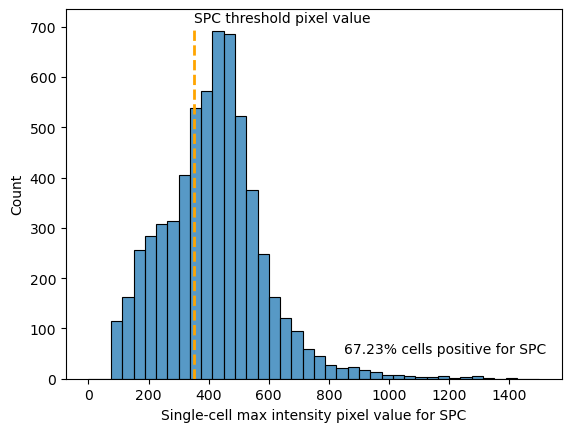

In [123]:
sns.histplot(df['Max. int. SPC'], binrange=(0,1500), bins = 40, kde=False)
plt.vlines(x=spc_thresh, ymin = 0, ymax = 700, linewidth = 2, color = 'orange', linestyle = 'dashed')
plt.text(x = spc_thresh, y = 710, s = 'SPC threshold pixel value')
plt.text(x = 850, y = 50, s = f'{percentage_pos_spc}% cells positive for SPC')
plt.xlabel('Single-cell max intensity pixel value for SPC')
plt.savefig('/home/dayn/data/lung_on_chip/coculture/DAPI-SPC-PDPN-ZO1_20220808/dist_max_pixel_values_spc.jpg', dpi = 314, bbox_inches = 'tight')